# Moon et al
Correctness Ranking Loss (CRL) used for improving the performance of neural network models, particularly in their ability to predict failures (or misclassifications).
Purpose and Outcome: The main goal of CRL is to help the model not only be accurate in its predictions but also to understand and quantify its certainty in those predictions. This can be particularly useful in scenarios where understanding the model's confidence in its predictions is crucial, such as in medical diagnostics or autonomous driving.

In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [4]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'Cifar_baseline.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'Dropout.ipynb', 'FocalLoss.ipynb', 'LabelSmoothing.ipynb', 'Mixup.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_LS.json', 'results_ECE_OD.json', 'results_ECE_OD_CRL.json', 'results_ECE_OD_LS.json', 'results_ECE_OD_baseline.json', 'results_ECE_OD_dropout.json', 'results_ECE_OD_mixup.json', 'results_ECE_baseline.json', 'results_ECE_cifar_baseline.json', 'results_ECE_cifar_baseline_OD.json', 'results_ECE_cifar_da

In [5]:
import numpy as np
import os
import json
import random
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd


def fsw_labels_to_csv():
    annotations = []
    src_path = "data/raw/hx_fsw/images/"
    for seam_nr in range(1, 115):
        for ann_file in os.listdir(f"{src_path}{seam_nr}/annotations"):
            tree = ET.parse(f"{src_path}{seam_nr}/annotations/{ann_file}")
            item = {}
            for child in tree.getroot():
                item[child.tag] = child.text
            item["img_path"] = f"{src_path}{seam_nr}/cutouts/"+item["filename"]
            item["seam_nr"] = seam_nr  # This adds the seam_nr value to each annotation item
            item.setdefault('temp_label', None)
            item.setdefault('grat_label', None)
            item.setdefault('inner_label', None)
            annotations.append(item)


    df = pd.DataFrame(annotations)
    df.to_csv("data/raw/hx_fsw/annotations.csv", sep=";")


def fsw_make_annotations():
    def df_to_list(df):
        data = [{"img_path": x.replace("../", ""), "seam_nr": y, "Group": m, "labels": (z1, z2, z3)}
            for x, y, z1, z2, z3 , m in zip(df['img_path'], df["Weld Seam Nr."], df['temp_label'], df['grat_label'], df['inner_label'], df['Group'])]
        return data

    df = pd.read_csv("data/raw/hx_fsw/annotations.csv", sep=";")
    all_data = df_to_list(df)

    # Filter out data from groups 1, 2, and 3 for cross-validation
    filtered_data = [d for d in all_data if d['Group'] in [1, 2, 3]]
    # OD data for model evaluation
    OD_data = [d for d in all_data if d['Group'] in [5,6,7]]

    # Shuffle filtered_data
    random.shuffle(filtered_data)
    random.shuffle(OD_data)
    # Set the number of splits for cross-validation
    num_splits = 5
    split_size = len(filtered_data) // num_splits

    cv_anns = {}

    for split in range(num_splits):
        # Create train, validation, and test splits
        start = split * split_size
        end = start + split_size
        test_data = filtered_data[start:end]

        train_data = filtered_data[:start] + filtered_data[end:]
        train_end = len(train_data) - len(train_data) // 3
        train_data, val_data = train_data[:train_end], train_data[train_end:]

        cv_anns[split + 1] = {
            "train": train_data,
            "val": val_data,
            "test": test_data,
            "ODdata": OD_data[:500]
        }

        print(f"Split {split + 1}: Train = {len(train_data)}, Val = {len(val_data)}, Test = {len(test_data)}, OD = {len(OD_data)}")

    # Write the cross-validation annotations to a file
    with open("data/raw/hx_fsw/cv_annotations.json", "w") as file:
        file.write(json.dumps(cv_anns, indent=4))


In [6]:
fsw_make_annotations()

Split 1: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 2: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 3: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 4: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 5: Train = 1480, Val = 740, Test = 554, OD = 4018


In [7]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image


class FSWDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        """
        Overwrites the methods of the pytorch dataset class and defines
        how to return an image and a label

        Args:
            paths: list with image paths
            labels: list with labels
            transform: None or torchvision transforms to apply to image
        """

        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # load specific sample
        img = Image.open(self.paths[idx])
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        # apply transforms
        if self.transform is not None:
            img = self.transform(img)

        return img, label


class AddNoiseToTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the normal distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):

        # tip: use pytorch for random operations, since it handles management of random seeds in
        # workers of dataloader correctly. Numpy for example doesn't, which results in identical samples
        if torch.rand(1) < self.p:
            # add noise from normal distribution to tensor with a given probability
            return x + torch.randn_like(x) * self.a
        return x


class AdjustBrightnessOfTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the uniform distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):
        if torch.rand(1) < self.p:
            # add brightness value from uniform distribution to tensor with a given probability
            x = x + (torch.rand(1) - 0.5) * self.a
            x = torch.where(x < 1., x, 1.)
            x = torch.where(x > 0., x, 0.)
        return x


In [8]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
for cv_i in [str(x) for x in range(1, 5)]:
    # get paths and labels
    label_i = 1  # (grat)
    num_classes = 2  # (grat)
    with open(f"data/raw/hx_fsw/cv_annotations.json") as file:
        data = json.load(file)

    vl_paths = [sample["img_path"] for sample in data[cv_i]["val"]]
    vl_labels = [sample["labels"][label_i] for sample in data[cv_i]["val"]]
    ts_paths = [sample["img_path"] for sample in data[cv_i]["test"]]
    ts_labels = [sample["labels"][label_i] for sample in data[cv_i]["test"]]
    tr_paths = [sample["img_path"] for sample in data[cv_i]["train"]]
    tr_labels = [sample["labels"][label_i] for sample in data[cv_i]["train"]]

    # prep for the OD data
    OD_paths = [sample["img_path"] for sample in data[cv_i]["ODdata"]]
    OD_labels = [sample["labels"][label_i] for sample in data[cv_i]["ODdata"]]




tr_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddNoiseToTensor(p=0.5, alpha=0.1),
])

vl_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# build datasets and dataloaders
train_dataset = FSWDataset(paths=tr_paths, labels=tr_labels, transform=tr_transform)
test_dataset = FSWDataset(paths=ts_paths, labels=ts_labels, transform=vl_transform)
val_dataset = FSWDataset(paths=vl_paths, labels=vl_labels, transform=vl_transform)
OD_dataset = FSWDataset(paths=OD_paths, labels=OD_labels, transform=vl_transform)

All models are trained using SGD with a momentum
of 0.9, an initial learning rate of 0.1, and a weight decay of 5e-4 for 200 epochs
with the mini-batch size of 128 on CIFAR-10 and CIFAR-100. The learning rate is
reduced by a factor of 10 at 80, 130, and 170 epochs. We randomly sample 10% of
training samples as a validation dataset for each task because it is a requirement
for post-calibration methods like temperature scaling [15]. For each experiment,
the mean and standard deviation over three random runs are reported

In [9]:
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import random

# Add a Dropout layer followed by the final Linear layer
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader= DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
OD_loader= DataLoader(OD_dataset, batch_size=128, shuffle=False, num_workers=4)

For public pretrained ResNet50 model initialization

In [10]:
import torch
import torchvision.models as models
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.0MB/s]


For the model used in the paper

In [11]:
# from model import LeNet
# from model import AlexNet
# from model import resnet
# from model import resnet18
# from model import densenet_BC
# from model import vgg
# from model import mobilenet
# from model import efficientnet
# from model import wrn
# from model import convmixer

# num_cls
# model_dict = {
#         "num_classes": num_class,
#     }
# model = resnet.resnet110(**model_dict).cuda()

# #other possible model initialization
# model = resnet18.ResNet18(**model_dict).cuda()
# model = vgg.vgg16(**model_dict).cuda()

In [12]:
pip install tqdm tensorboard

# Ad-hoc:
label smoothing
In standard classification tasks, the target labels are often one-hot encoded, meaning a label is represented as 1 for the correct class and 0 for all other classes.
Label smoothing modifies these target labels by reducing the target value for the correct class slightly below 1 and distributing a small amount of this value across the other classes.**bold text**

In [13]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def crl_loss(output, target, history, lambda_rank):
    conf = torch.softmax(output, dim=1)
    confidence, _ = conf.max(dim=1)

    rank_input1 = confidence
    rank_input2 = torch.roll(confidence, -1)
    idx = torch.arange(confidence.size(0), device=confidence.device)
    idx2 = torch.roll(idx, -1)

    rank_target, rank_margin = history.get_target_margin(idx, idx2)
    rank_target_nonzero = rank_target.clone()
    rank_target_nonzero[rank_target_nonzero == 0] = 1
    rank_input2 = rank_input2 + rank_margin / rank_target_nonzero

    ranking_loss = torch.max(torch.zeros_like(rank_input1), -torch.sign(rank_target) * (rank_input1 - rank_input2) + torch.abs(rank_margin))
    cls_loss = torch.nn.functional.cross_entropy(output, target)
    return cls_loss + lambda_rank * ranking_loss.mean()


#track the correctness of each sample over training epochs and calculate the margin for the CRL loss.
# This buffer will store the proportion of times each sample in the training dataset has been correctly classified.

class HistoryBuffer:
    def __init__(self, dataset_size, device):
        self.correct_count = torch.zeros(dataset_size, device=device)
        self.total_count = torch.zeros(dataset_size, device=device)

    def update(self, outputs, targets, indices):
        with torch.no_grad():
            predictions = outputs.max(1)[1]  # Get the predicted class
            correct = (predictions == targets).float()  # Compare with true labels
            self.correct_count[indices] += correct
            self.total_count[indices] += 1

    def get_correct_rate(self, indices):
        correct_rate = self.correct_count[indices] / self.total_count[indices]
        correct_rate[self.total_count[indices] == 0] = 0  # Avoid division by zero
        return correct_rate

    def get_target_margin(self, idx1, idx2):
        correct_rate1 = self.get_correct_rate(idx1)
        correct_rate2 = self.get_correct_rate(idx2)
        rank_target = torch.sign(correct_rate1 - correct_rate2)
        rank_margin = torch.abs(correct_rate1 - correct_rate2)
        return rank_target, rank_margin

train_losses = []
val_accuracies = []
dataset_size = len(train_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Updated Parameters
num_epochs = 10
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
lambda_rank = 0.1  # Weight for the ranking loss in the total loss
batch_size = 128
history = HistoryBuffer(dataset_size, device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Generate indices for the current batch
        # Assuming your DataLoader does not shuffle data after each epoch
        start_idx = batch_idx * train_loader.batch_size
        end_idx = start_idx + inputs.size(0)
        indices = torch.arange(start_idx, end_idx, device=device)

        loss = crl_loss(outputs, labels, history, lambda_rank)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        history.update(outputs, labels, indices)  # Update the history buffer with the latest predictions


    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

print("Finished Training")


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 1/10] Loss: 1.7417 - Val Accuracy: 68.65%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 2/10] Loss: 0.1708 - Val Accuracy: 93.24%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 3/10] Loss: 0.0913 - Val Accuracy: 97.57%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 4/10] Loss: 0.0466 - Val Accuracy: 97.84%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 5/10] Loss: 0.0367 - Val Accuracy: 99.46%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 6/10] Loss: 0.0193 - Val Accuracy: 99.73%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 7/10] Loss: 0.0283 - Val Accuracy: 99.19%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 8/10] Loss: 0.0110 - Val Accuracy: 99.19%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 9/10] Loss: 0.0101 - Val Accuracy: 99.59%


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 10/10] Loss: 0.0074 - Val Accuracy: 99.73%
Finished Training


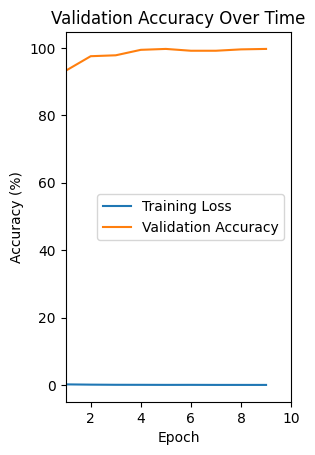

In [14]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [15]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 99.46%
Average Test Loss: 0.0146


In [16]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model, OD_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 83.20%
Average Test Loss: 0.9089


In [17]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.0053


In [18]:
# Sample test result and current datetime
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_CRL.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


In [19]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 1.0000


In [20]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc_CRL.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [21]:
import torch.nn.functional as F

# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)


model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")


Expected Calibration Error (ECE): 0.1240


In [22]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD_CRL.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')

In [23]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc_OD = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 1.0000


In [24]:
# Sample test result and current datetime
result_auroc_OD = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc_OD  # Example accuracy value
}

# Saving the result to 'results.json'
with open('result_auroc_OD_CRL.json', 'a') as file:
    file.write(json.dumps(result_auroc_OD) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD